In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv('statics/btc_jpy/2017/2017_rate.csv')
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp']) +  pd.Timedelta(hours=9)
btc_path = 'statics/btc_jpy/'
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'], format='%Y-%m-%dT%H:%M:%S:000Z')
data2 = pd.read_csv('statics/btc_jpy/2017/11_month.csv')

In [43]:
#年ごとにまとめたやつ
for year in range(2017, 2022):
    
    year_path = btc_path+str(year)
    data = pd.read_csv(year_path+'/1_month.csv')
    for month in range(2, 13):
        temp = pd.read_csv(year_path+'/'+str(month)+'_month.csv')
        data = pd.concat([data, temp], axis=0)
    
    #タイムスタンプを見やすい形にして、かつ日本時間に変換（pandasに便利なTimeクラスがあった）
    data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'], format='%Y-%m-%dT%H:%M:%S:000Z')
    data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp']) +  pd.Timedelta(hours=9)
    data = data.rename(columns={'utc_timestamp':'jpy_timestamp'})
    data.to_csv(year_path+'/'+str(year)+'_rate.csv', index=False)

In [77]:
data = pd.read_csv('statics/btc_jpy/2022/2022_rate.csv')
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp'], format='%Y-%m-%dT%H:%M:%S:000Z')
data['utc_timestamp'] = pd.to_datetime(data['utc_timestamp']) +  pd.Timedelta(hours=9)
data = data.rename(columns={'utc_timestamp':'jpy_timestamp'})
data.to_csv('statics/btc_jpy/2022/2022_rate.csv', index=False)

In [71]:
pd.Timestamp(year=2022, month=1, day=1)

Timestamp('2022-01-01 00:00:00')

In [44]:
#5年分を一つのcsvにする

data = pd.read_csv(btc_path+'2017/2017_rate.csv')
for year in range(2018, 2022):
    
    year_path = btc_path+str(year)
    temp = pd.read_csv(year_path+'/'+str(year)+'_rate.csv')
    data = pd.concat([data, temp], axis=0)

data.to_csv('statics/train/jpy_rates.csv', index=False)

In [78]:
data = pd.read_csv('statics/train/jpy_rates.csv')
data_22 = pd.read_csv('statics/btc_jpy/2022/2022_rate.csv')
concat = pd.concat([data, data_22], axis=0)

In [228]:
#リターン
ret = data.diff().dropna()/data.values[:-1]

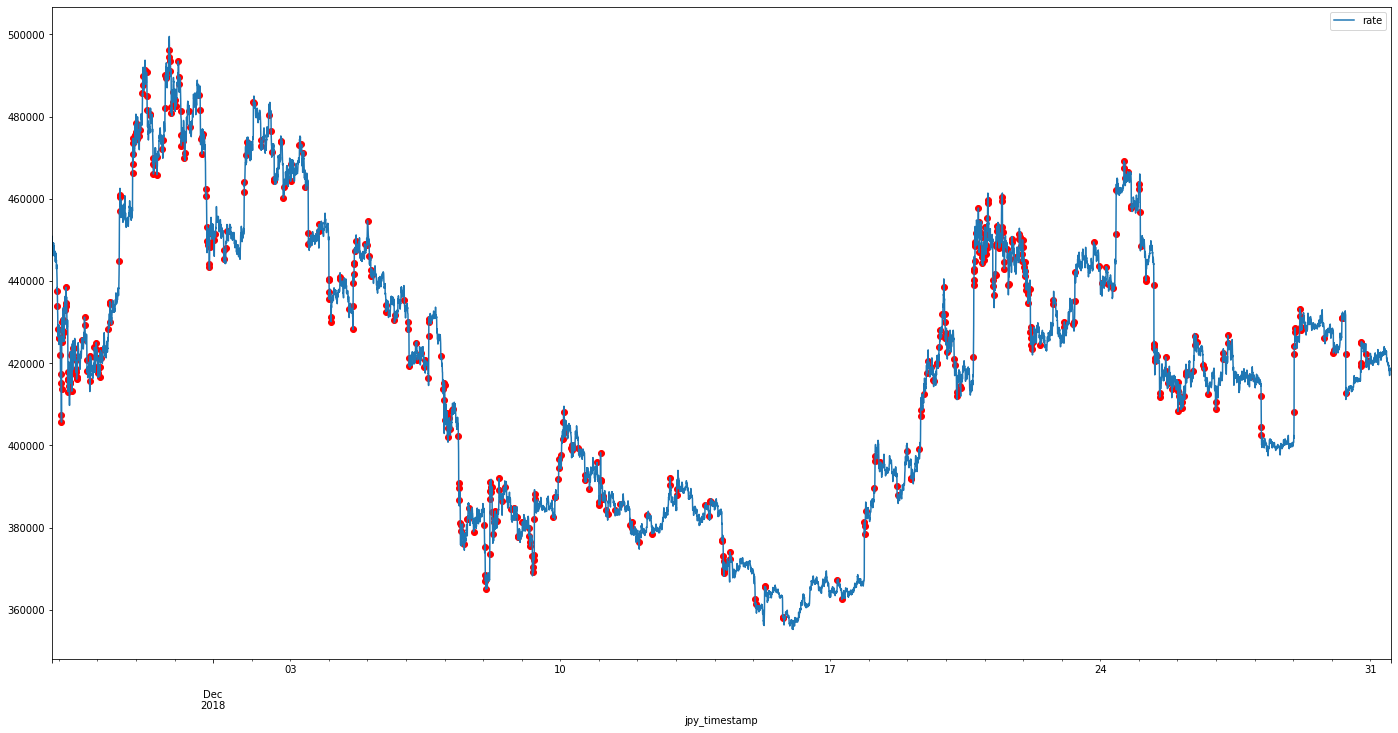

In [155]:
data_temp.plot(figsize=(24, 12))
plt.scatter(x=t_events, y=data_temp.loc[t_events], color='red')

In [501]:
#動的閾値を設定する。ボラリティを用いるが、どの範囲にするか....。日次か、時次か、など。とりあえず日次にします。
#やっぱり、ボラリティによってトリプルバリアの幅を決めるのであれば、今しようとしている数十分～数時間単位の取引
#では、６時間くらいのボラリティを見て、大きく変動してるなら目標↑、小さいなら↓、みたいにした方が良いと思う
#getDailyBVolだけど結局6時間前とのボラリティにしてるので注意→1時間ごとにした

In [524]:
data_temp = copy.deepcopy(data[430000:433000])
#リターン
ret = data_temp.diff().dropna()/data_temp.values[:-1]

#ボラリティ
vol = getDailyVol(data_temp)

#リターンというのはつまり変化率であって、その累積はボラリティということになる。平均ボラリティの0.5倍が良さそう。
t_events_vol = getTEvents(ret, vol.mean().values*1.2)
print(len(t_events_vol))

191


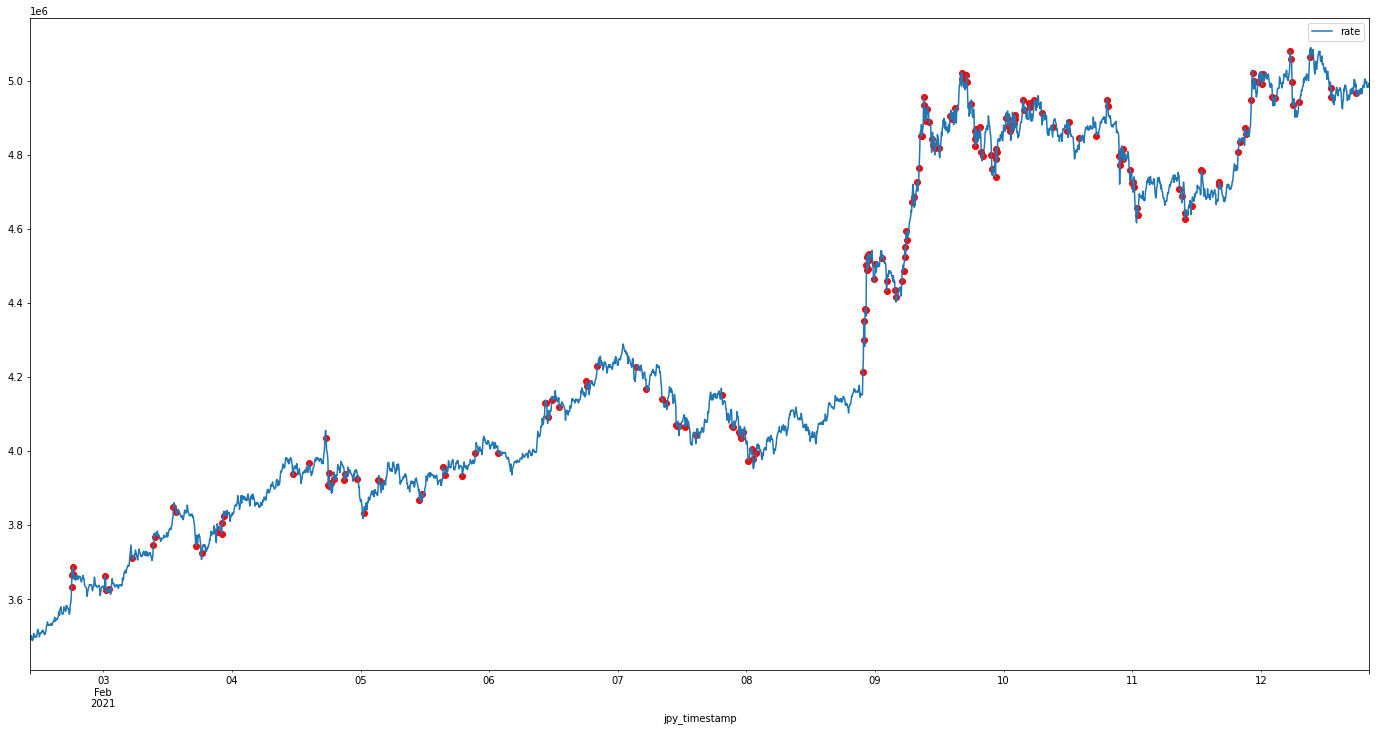

In [525]:
#確かにこれを見ると特にイベントがない（平坦）な時にはあんまり抽出していないな。平坦で急に上がるのは外れ値みたいなもんだし、理論的にも納得できる。
data_temp.plot(figsize=(24, 12))
plt.scatter(x=t_events_vol, y=data_temp.loc[t_events_vol], color='red')

array([[<AxesSubplot:title={'center':'rate'}>]], dtype=object)

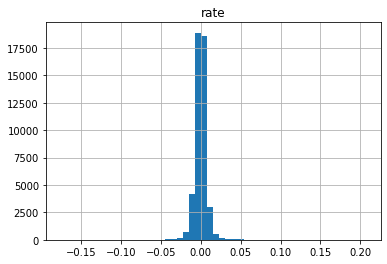

In [340]:
ret.loc[t_events_vol].hist(bins=50)

array([[<AxesSubplot:title={'center':'rate'}>]], dtype=object)

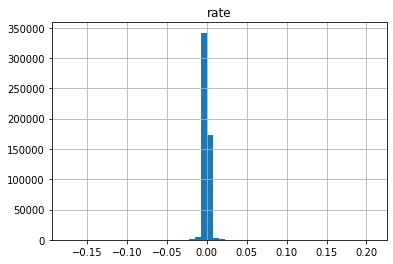

In [303]:
#確かに抽出した方が良い感じの分布になってるな
ret.hist(bins=50)

In [181]:
#pandasのewmは期間がこれまでずっとなので効率が悪そう。termによって直近どれくらいのデータを見るのかを指定（time型が良いか)
import copy

def ewm_std(close, term, span):

    df = copy.deepcopy(close)
    N = span
    a = 2./(1+N)
    time_delta = term
    term_num = df[:df.index[0] + time_delta].shape[0] #time_deltaの分だけの期間のデータ個数

    df_raw = np.pad(df.values[:,0], [term_num-1, 0])
    stdcalc = []

    # Get weights: w
    w = (1-a)**np.arange(term_num) # This is reverse order to match Series order ←np.convolveがクソみたいな仕様なので逆向きやめた。
    w_inv = w[::-1]
    sum_w = np.sum(w)

    # Calculate exponential moving average
    ewma = np.convolve(df_raw, w, mode='valid') / sum_w


    # Calculate bias
    bias = np.sum(w)**2 / (np.sum(w)**2 - np.sum(w**2))

    # Calculate exponential moving variance with bias
    stdcalc = np.array([bias * np.sum(w_inv * (df_raw[i : i+term_num] - ewma[i])**2) / sum_w for i in range(df.shape[0])])
    
    #ewmvar = bias * np.sum(w * (z - ewma)**2) / np.sum(w)

    
    stdcalc = pd.DataFrame(np.sqrt(stdcalc), index=df.index, columns=['vol'])

    return stdcalc


#平均バージョン
def ewm_mean(close, term, span):

    df = copy.deepcopy(close)
    N = span
    a = 2./(1+N)
    time_delta = term
    term_num = df[:df.index[0] + time_delta].shape[0] #time_deltaの分だけの期間のデータ個数

    df_raw = np.pad(df.values[:,0], [term_num-1, 0])
   
    # Get weights: w
    w = (1-a)**np.arange(term_num) # This is reverse order to match Series order ←np.convolveがクソみたいな仕様なので逆向きやめた。
    sum_w = np.sum(w)

    # Calculate exponential moving average
    ewma = np.convolve(df_raw, w, mode='valid') / sum_w

    ewma_df = pd.DataFrame(ewma, index=df.index, columns=['mean'])

    return ewma_df



def getVol(close, ret_delta, term, span0=100):
    df0 = close.index.searchsorted(close.index-ret_delta, side='right')
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0-1], index=close.index[close.shape[0] - df0.shape[0]:])

    df0 = close.loc[df0.index]/close.loc[df0.values].values - 1
    df0 = ewm_std(df0, term=term, span=span0)
    return df0.dropna()




#CUSUMフィルタ。その時点のボラリティから動的閾値を計算する方式に変更。トリプルバリアも動的閾値だし、こっちもそうするのが普通だという考え。
def getTEvents(gRaw, vol):
    '''
    本書のサンプルコード
    '''
    tEvents, sPos, sNeg = [], 0, 0
    diff = gRaw.diff().dropna()/gRaw.values[:-1] #そもそも絶対差(diff())のみじゃスケール依存なのでリターンみたいに割るべき
    offset = np.where(diff.index==vol.index[0])[0][0]
    diff = diff.values[:, 0]
    np_vol = np.array(vol)[:, 0]
    
    for p, i in enumerate(vol.index):
        sPos, sNeg = max(0, sPos + diff[offset+p]), min(0, sNeg + diff[offset+p])
        h = np_vol[p]
        
        #hが低すぎると過剰イベントに、高すぎると過疎になるので防止
        if h < 0.005:
            h = 0.005
        
        elif h > 0.008:
            h = 0.008
        
        if sNeg < -h:
            sNeg = 0
            tEvents.append(i)
        elif sPos > h:
            sPos = 0
            tEvents.append(i)
    
    return pd.DatetimeIndex(tEvents)

In [182]:
#設定するパラメータ群は、ボラリティを何次リターンをもとにするか、ボラリティの計算区間（期間）はどれくらいか、
#CUSUMフィルタでのh(イベントトリガーの閾値)、垂直バリアの期間、トリプルバリアの利食い、ストップロスの割合

#リターン
ret = data.diff().dropna()/data.values[:-1]

#ボラリティ計算用パラメータ
ret_delta = pd.Timedelta(hours=1) #何次リターンにするか。6時間にしてたけど、明らかにボラリティの変化が遅れてしまってリアルタイムではないので狭めます。
vol_term = pd.Timedelta(days=10) #過去どれくらいの期間で計算するか


vol = getVol(data, ret_delta, vol_term) #ボラリティ計算。

In [183]:
#CUSUMでの閾値。グラフ見てhはその都度変えた方が良いことに気付いた（ボラリティが高いとこでは過剰サンプルが起きるし、低いとこでは疎になってしまう）
#h = vol.mean().values*0.5
t_events = getTEvents(data, vol)
print(t_events.size)

48280


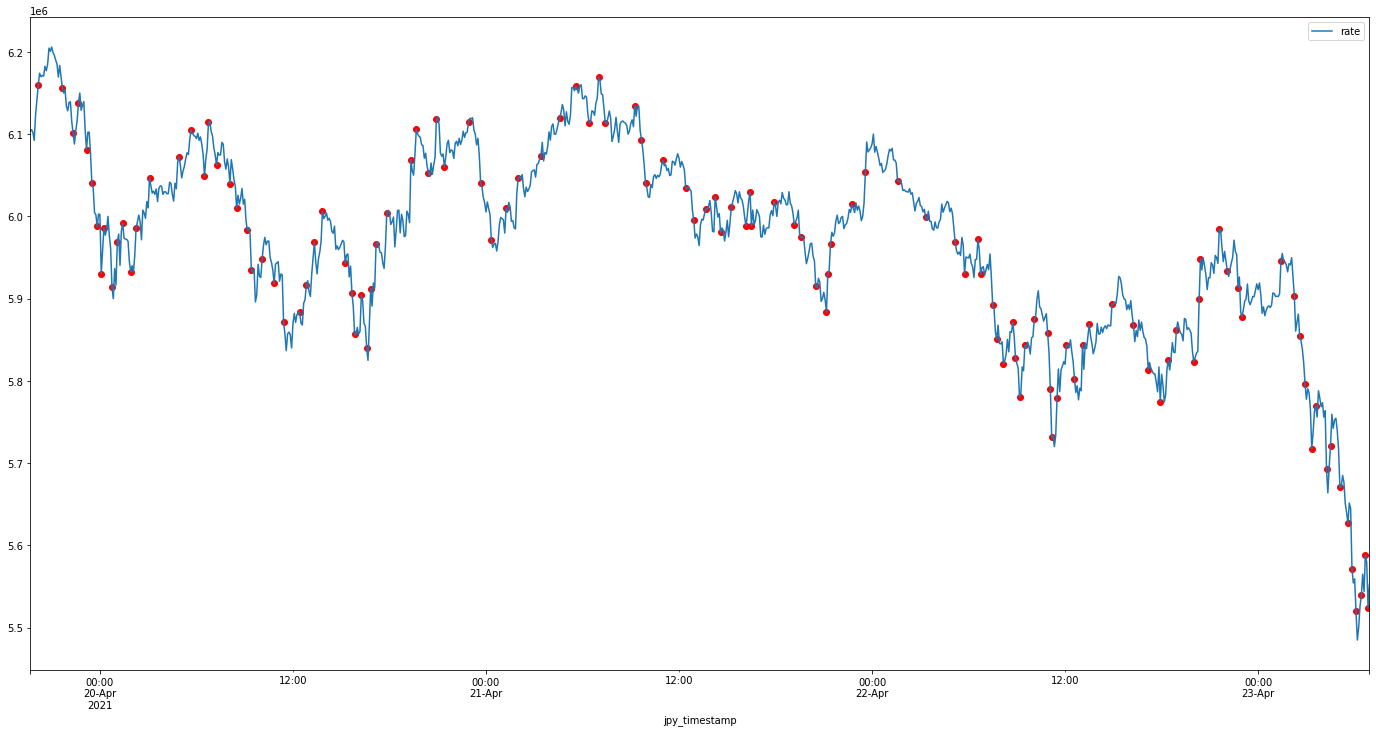

In [888]:
#イベントがどんな感じか確認
data_temp = copy.deepcopy(data[452000:453000])
start = data_temp.index[0]
end = data_temp.index[-1]
times_temp = t_events[(t_events>=start) & (t_events<=end)]
data_temp.plot(figsize=(24, 12))
plt.scatter(x=times_temp, y=data_temp.loc[times_temp], color='red')

<AxesSubplot:xlabel='jpy_timestamp'>

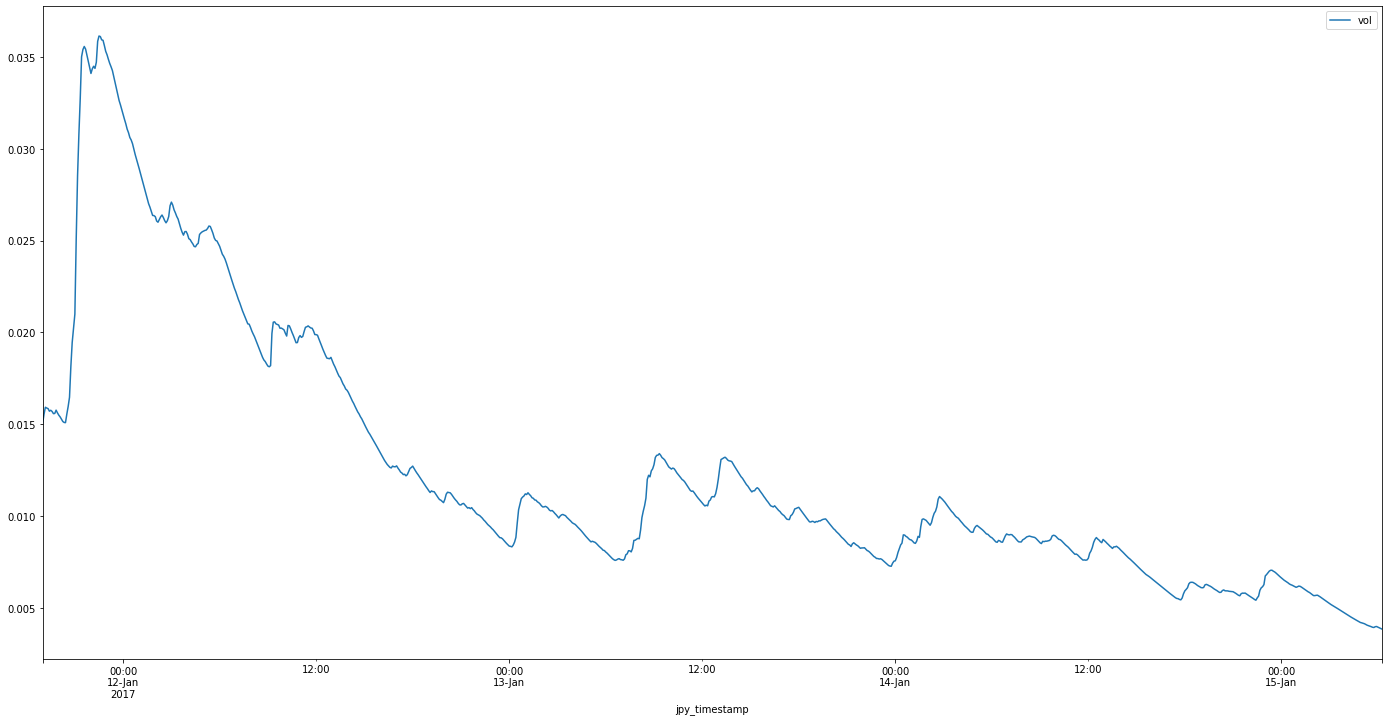

In [883]:
vol[start:end].plot(figsize=(24,12))

In [184]:
#垂直バリアの作成。とりあえず4時間以内。→6時間に変更。待ってもいい時間。
vertical_delta = pd.Timedelta(hours=6)

vertical_barrier = t_events + vertical_delta
events = pd.DataFrame(vertical_barrier)
events.index = t_events
events.columns = ['t1']
events['trgt'] = vol
events = events.dropna()

events

,t1,trgt
2017-01-01 15:05:00,2017-01-01 21:05:00,0.000839
2017-01-01 18:20:00,2017-01-02 00:20:00,0.001231
2017-01-01 19:15:00,2017-01-02 01:15:00,0.001292
2017-01-02 00:05:00,2017-01-02 06:05:00,0.002426
2017-01-02 01:05:00,2017-01-02 07:05:00,0.002255
...,...,...
2022-01-01 03:45:00,2022-01-01 09:45:00,0.012998
2022-01-01 04:20:00,2022-01-01 10:20:00,0.012356
2022-01-01 04:50:00,2022-01-01 10:50:00,0.012507
2022-01-01 05:15:00,2022-01-01 11:15:00,0.012198


In [186]:
#トリプルバリア
def applyPtSlOnT1(close, events, ptSl, molecule=None):
    # t1(イベント終了)前に行われた場合は、ストップロス/利食いを実施
    events_ = copy.deepcopy(events) #.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pd.Series(index=events.index)
    
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        pd.Series(index=events.index)
    

    sl_values = np.zeros(events.shape[0], dtype='datetime64[s]')
    pt_values = np.zeros(events.shape[0], dtype='datetime64[s]')
    idx = 0
    for loc, t1 in events_['t1'].iteritems(): #(index, value)でiter
        df0 = close[loc:t1] # 価格経路
        df0 = (df0 / close.loc[loc] - 1) #* events_.at # リターン
        
        loss = sl[loc]
        profit = pt[loc]
        
        
        #損益幅が大きすぎると機能しないので、最低でも1.0%下がるのはやめたい。つまり最大幅を0.01にする
        if loss < -0.02:
            loss = -0.02

        #利益は最低でも0.5%は欲しいし、1.0%で十分
        if profit > 0.01:
            profit = 0.01
        
        elif profit < 0.005:
            profit = 0.005

        # ストップロスの最短タイミング
        sl_value = df0[df0.values <= loss].index.min()
        if sl_value is pd.NaT:
            sl_values[idx] = np.datetime64('NaT')
        else:
            sl_values[idx] = sl_value
        
        pt_value = df0[df0.values >= profit].index.min()
        # 利食いの最短タイミング
        if pt_value is pd.NaT:
            pt_values[idx] = np.datetime64('NaT')
        else:
            pt_values[idx] = pt_value
        
        idx += 1
    
    out['sl'] = sl_values
    out['pt'] = pt_values
    
    return out


#ラベリング
def getBins(events, close):
    #1) イベント発生時の価格
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    
    #2) outオブジェクトの生成
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index] - 1
    out['bin'] = np.sign(out['ret'])
    out.loc[out['bin']<=0, 'bin'] = 0
    return out

In [187]:
#
ptSl = [1, 1]
tp_events = applyPtSlOnT1(data, events, ptSl)
t1_events = pd.DataFrame(tp_events.min(axis=1), columns=['t1']) #最初にトリプルバリアに触れた時の時刻群

In [188]:
#labelsの最終2行はNaTになってた。というのは、slもptもNaTかつ垂直バリアもデータ外(2022年に食い込む)だったので、値がない
labels = getBins(t1_events, data).dropna()

array([[<AxesSubplot:title={'center':'ret'}>,
        <AxesSubplot:title={'center':'bin'}>]], dtype=object)

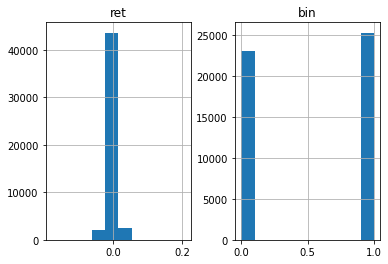

In [1017]:
labels.hist()

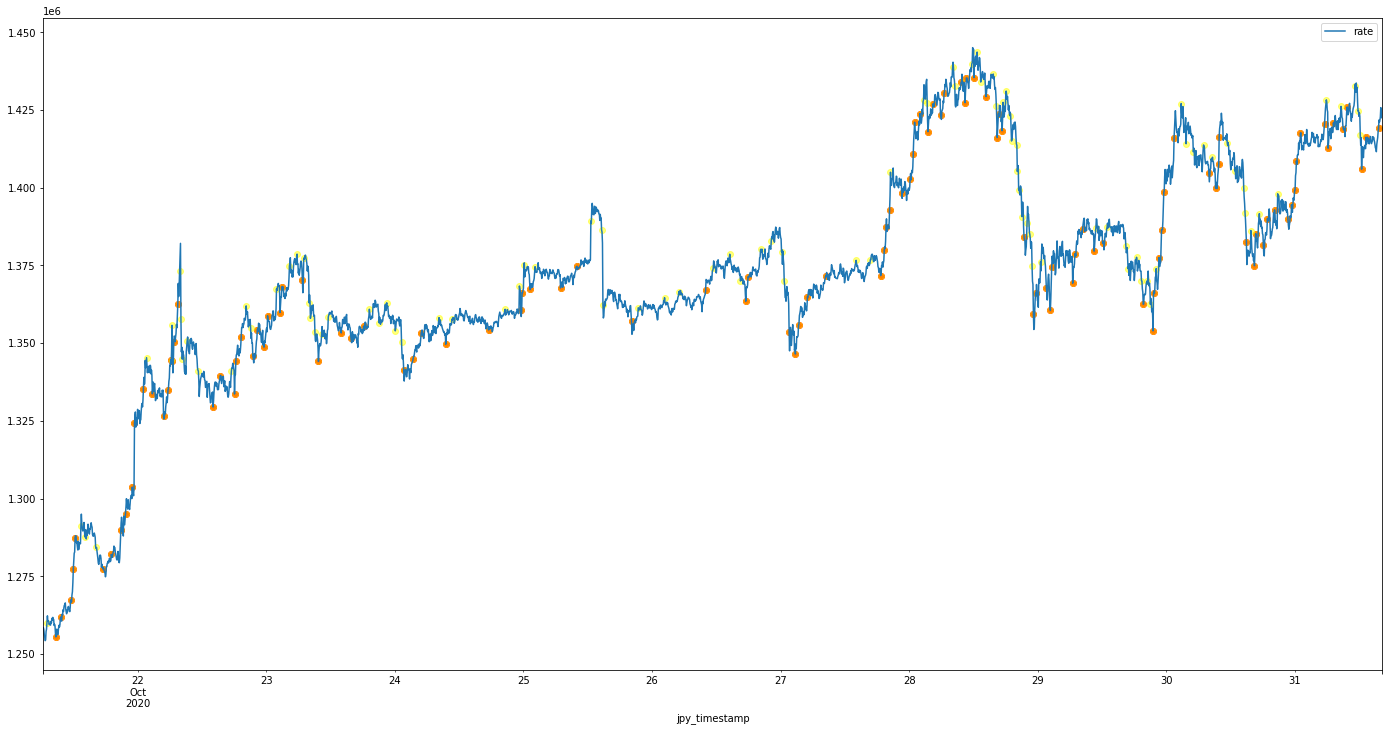

In [1020]:
data_temp = copy.deepcopy(data[400000:403000])
times = labels[labels['bin']==1.0].index
start = data_temp.index[0]
end = data_temp.index[-1]
times_temp = times[(times>=start) & (times<=end)]
data_temp.plot(figsize=(24, 12))
plt.scatter(x=times_temp, y=data_temp.loc[times_temp], color='red')
plt.scatter(x=t_events[(t_events>=start) & (t_events<=end)], y=data_temp.loc[t_events[(t_events>=start) & (t_events<=end)]], color='yellow', alpha=0.5)

<AxesSubplot:>

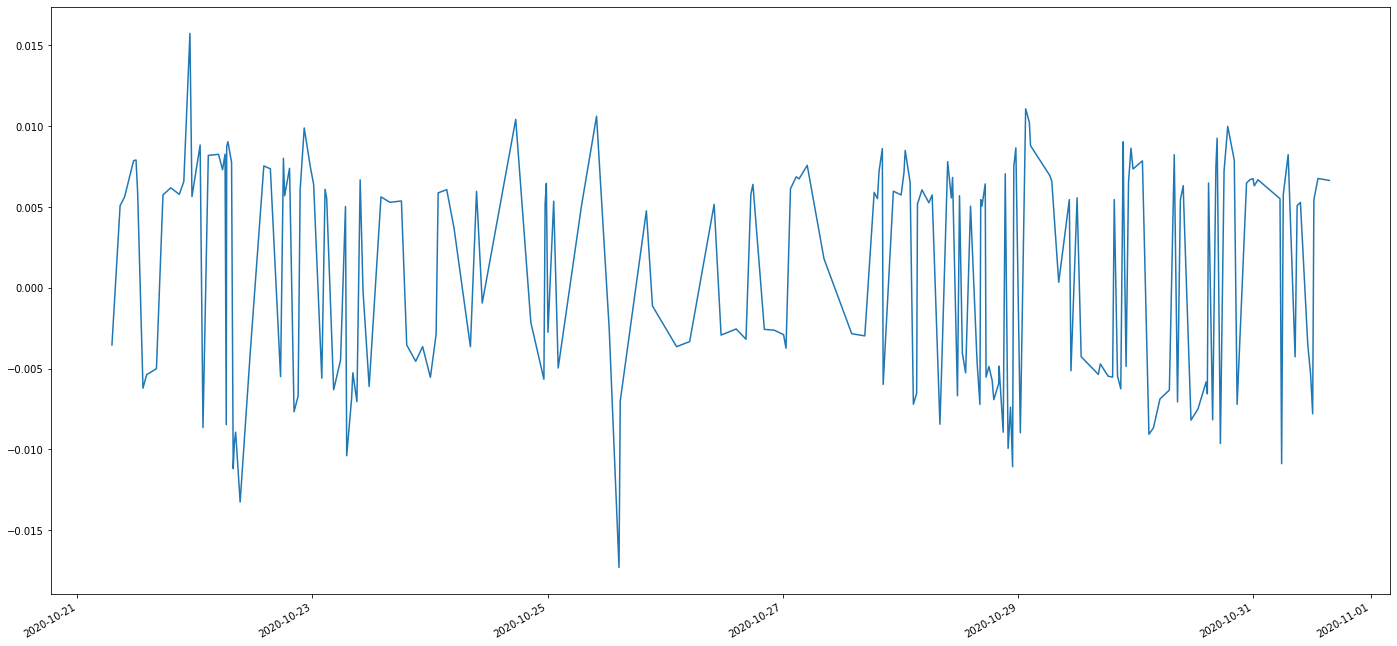

In [1021]:
labels.ret[start:end].plot(figsize=(24,12))

In [984]:
tp_events.shape

(48280, 3)

<AxesSubplot:>

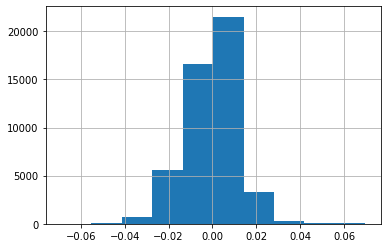

In [1048]:
labels['ret'][(labels['ret']<0.07) & (labels['ret']>-0.07)].hist()

In [1050]:
abs(labels['ret']).mean()

0.01065765440261565

In [672]:
#pandasのewmの中身（ネットから拝借）。全然spanは期間とかみたいに扱われてなくて笑う。ただweight計算に使われてるだけじゃん。
#これまで全てのデータの指数加重平均を使って、指数加重標準偏差を計算していると。過去何個のデータを使うとかはやらなくていいのかなぁ。
#結局加重の影響で昔すぎるやつはほぼ影響０になるのは分かるけど...。

In [152]:
def std_max_min(array):
    max = np.nanmax(array)
    min = np.nanmin(array)
    return (array - min) / (max - min)

In [204]:
np.where((keys<=np.datetime64('2017-01-04T09:20:00')) | (keys>=np.datetime64('2019-12-04T10:20:00')))

(array([    0, 28525, 28526, ..., 48235, 48236, 48237], dtype=int64),)

In [229]:
labels_co = copy.deepcopy(labels)

In [230]:
labels_co['weight'] = 1.0
labels_co['weight'][abs(labels['ret'])<0.01] = 0.8
labels_co['weight'][abs(labels['ret'])<0.001] = 0.4


In [275]:
bin = abs(labels_co.bin.values-1)
weig = labels_co['weight'].values
weighted_label = np.identity(2)[-bin.astype('int64')]*weig[:, None]

In [277]:
weighted_label[100]

array([0., 1.])

In [6]:
features = np.load('features.npy', allow_pickle=True).tolist()
labels = np.load('labels.npy', allow_pickle=True)

In [69]:
labels = np.load('labels.npy', allow_pickle=True)

In [17]:
keys = features.keys()
keys = np.array(list(keys)).astype('datetime64[s]')

In [25]:
np.cumsum(w_labels)

array([8.00000e-01, 8.00000e-01, 1.60000e+00, ..., 4.28844e+04,
       4.28854e+04, 4.28854e+04])

In [76]:
#divは分割グループ数。test_goupは[1,2]なら0-9のうち1,2をテストデータとするという意味
#これはindicesを返す。term分が重ならないようにtrainは端を消す
def split_cvcs(times, div, test_group, term):
    length = len(times)
    unit = length//div #1グループあたりのデータ数
    indices = np.arange(length)
    test1 = indices[unit*test_group[0] : unit*(test_group[0]+1)]
    test2 = indices[unit*test_group[1] : unit*(test_group[1]+1)]
    test_indices = np.concatenate([test1, test2])
    
    #term分重ならないように訓練データを消す
    t1_start = times[test1[0]]-term; t1_end = times[test1[-1]]+term
    t2_start = times[test2[0]]-term; t2_end = times[test2[-1]]+term

    train_indices = np.where((times<=t1_start) | 
                            ((times>=t1_end) & (times<=t2_start)) |
                            (times>=t2_end))[0]
    return train_indices, test_indices

In [97]:
train, test = split_cvcs(keys, 10, [0,1], pd.Timedelta(days=3))

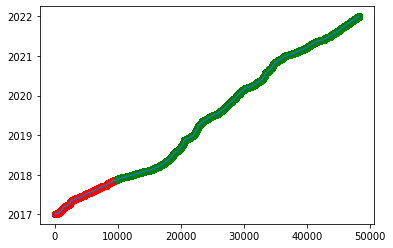

In [98]:
plt.plot(keys)
plt.scatter(test,keys[test], color='red')
plt.scatter(train, keys[train], color='green')

In [6]:
import LSTM_model.train_ver2 as models

In [8]:
import torch
import torch.nn as nn
device = torch.device('cuda')
LSTM1 = models.CNN_BiLSTMNet1(input_size=9, output_size=2, hidden_size=64, dropout=0.2, kernel_size=5).to(device)
LSTM2 = models.CNN_BiLSTMNet2(input_size=6, output_size=2, hidden_size=64, dropout=0.2, kernel_size=5).to(device)
LSTM3 = models.CNN_LSTMNet(input_size=6, output_size=2, hidden_size=64, dropout=0.2, kernel_size=5).to(device)

In [8]:
LSTM1.load_state_dict(torch.load('LSTM_model/models_ver2/Bidirectional_CNN_LSTM_FFDAdd/model[8, 9].pth'))
LSTM2.load_state_dict(torch.load('LSTM_model/models_ver2/Bidirectional_CNN_LSTM/model[8, 9].pth'))
LSTM3.load_state_dict(torch.load('LSTM_model/models_ver2/CNN_LSTM/model[8, 9].pth'))

<All keys matched successfully>

In [10]:
LSTM1 = models.CNN_BiLSTMNet1(input_size=9, output_size=2, hidden_size=64, dropout=0.2, kernel_size=5).to(device)
LSTM1.load_state_dict(torch.load('LSTM_model/models_ver2/model[8, 9].pth'))

<All keys matched successfully>

In [58]:
features = np.load('LSTM_model/features/feature_1d.npy', allow_pickle=True).tolist()

In [59]:
labels = np.load('LSTM_model/labels/label_1d.npy', allow_pickle=True)
keys = features.keys()
keys = np.array(list(keys)).astype('datetime64[s]')

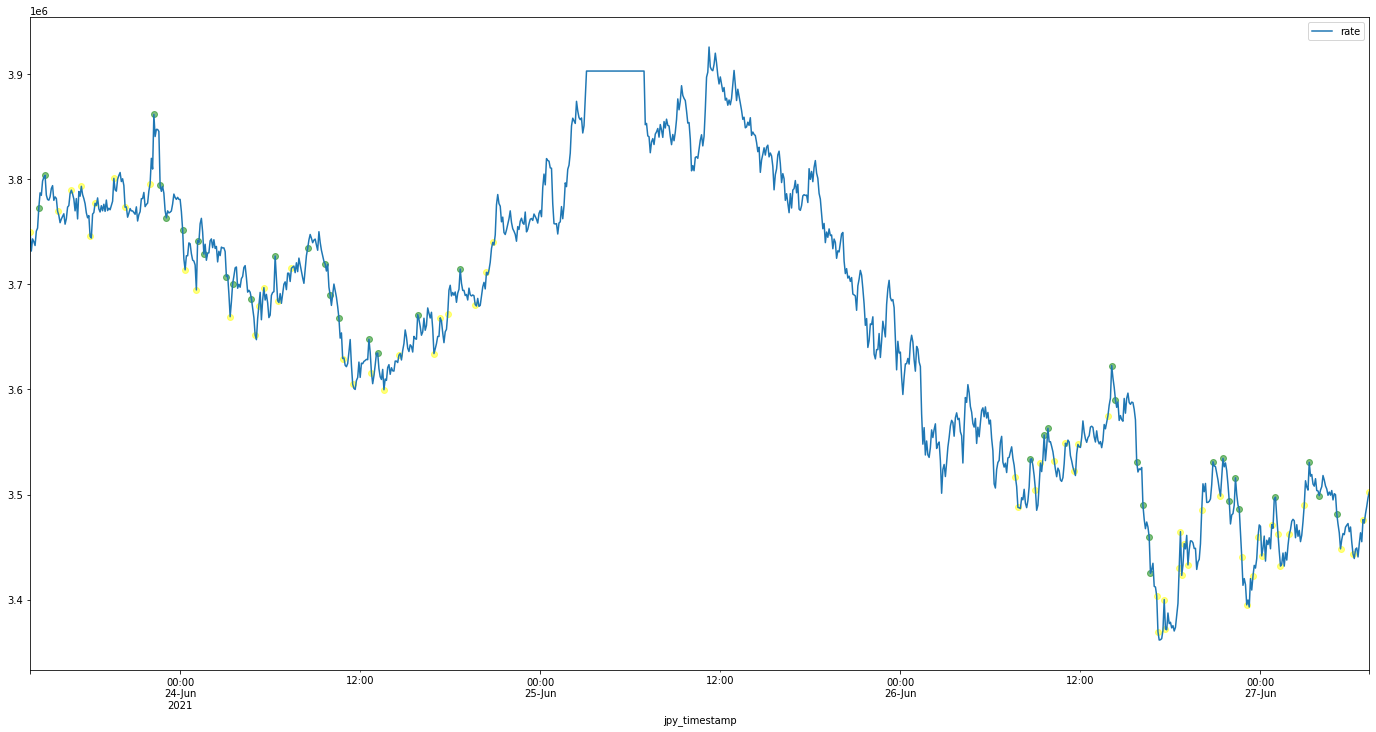

In [61]:
start = 43000
end = 43100
term = list(range(start, end))
key = keys[term]
#feature1 = torch.Tensor(list(features.values())[start:end]).float()[:,:,[1, 2, 3, 5, 6, 8, 10, 11, 15]].to(device)
#feature2 = torch.Tensor(list(features.values())[start:end]).float()[:,:,[1, 2, 3, 5, 8, 10]].to(device)
label = labels[start:end]
#LSTM1.eval()#; LSTM2.eval(); LSTM3.eval()

#predict1 = LSTM1(feature1)#; predict2 = LSTM2(feature2); predict3 = LSTM3(feature2)
buy_time = key[np.argmin(label, axis=1)==1]
sell_time = key[(np.argmin(label, axis=1)==1)==False]
#buy_time_pre = key[torch.argmin(predict1, axis=1).to('cpu')==1] #+ torch.argmin(predict2, axis=1) + torch.argmin(predict3, axis=1) >= 2).to('cpu')]
data.loc[key[0]:key[-1]].plot(figsize=(24,12))
#plt.scatter(buy_time_pre, data.loc[buy_time_pre], color='red')
plt.scatter(buy_time, data.loc[buy_time], color='yellow', alpha=0.5)
plt.scatter(sell_time, data.loc[sell_time], color='green', alpha=0.5)

In [23]:
from pandas import Timedelta
transforms = [models.Standardize(), models.Log_scale(),models. FFD(d=0.4, thres=0.01), #0-2
             models.Volatility(Timedelta(hours=0.5)), models.Volatility(Timedelta(hours=1)), #3-4
             models.Volatility(Timedelta(hours=2)), models.Volatility(Timedelta(hours=6)), models.Volatility(Timedelta(days=1)),  #5-7
             models.Moving_average(Timedelta(hours=0.5)), models.Moving_average(Timedelta(hours=1)), #8-9
             models.Moving_average(Timedelta(hours=2)), models.Moving_average(Timedelta(hours=6)),models. Moving_average(Timedelta(days=1)), #10-12
             models.FFD(d=0.6, thres=0.01), models.FFD(d=0.8, thres=0.01), models.FFD(d=1.0, thres=0.01)]

def make_features(t_idx):
    features = np.zeros([288, len(transforms)])
  
    #時刻からその位置インデックスを取得
    #t_idx = np.where(data.index == time)[0][0]

    for i, transform in enumerate(transforms):
        #時刻の位置インデックスとpast_numから、ndarrayだけで計算できるようにする
        feature = transform(data, t_idx, 288)
        features[:, i] = feature
    
    return features

In [24]:
ret = 0
unit = 0.005
stock = False #btcを持ってないならfalse、持っているならTrue
start = np.where(data.index == keys[45000])[0][0]
rates = data.values[:, 0]
times = data.index
buy_pre = []

LSTM1.eval()#; LSTM2.eval(); LSTM3.eval()

    
for i in range(start, start+5760):
    if i%100 == 0:
        print('%dステップ目'%(i))
    feature = torch.Tensor(make_features(i)).to(device)
    feature1 = feature[None, :, [1, 2, 3, 5, 6, 8, 10, 11, 15]]
    #feature2 = features[None, :, [1, 2, 3, 5, 8, 10]]
    

    predict1 = LSTM1(feature1)#; predict2 = LSTM2(feature2); predict3 = LSTM3(feature2)

    if torch.argmin(predict1, axis=1).to('cpu')==1: #+ torch.argmin(predict2, axis=1) + torch.argmin(predict3, axis=1) >= 2:
        buy_pre.append(0)
    
    else:
        buy_pre.append(1)

493600ステップ目
493700ステップ目
493800ステップ目
493900ステップ目
494000ステップ目
494100ステップ目
494200ステップ目
494300ステップ目
494400ステップ目
494500ステップ目
494600ステップ目
494700ステップ目
494800ステップ目
494900ステップ目
495000ステップ目
495100ステップ目
495200ステップ目
495300ステップ目
495400ステップ目
495500ステップ目
495600ステップ目
495700ステップ目
495800ステップ目
495900ステップ目
496000ステップ目
496100ステップ目
496200ステップ目
496300ステップ目
496400ステップ目
496500ステップ目
496600ステップ目
496700ステップ目
496800ステップ目
496900ステップ目
497000ステップ目
497100ステップ目
497200ステップ目
497300ステップ目
497400ステップ目
497500ステップ目
497600ステップ目
497700ステップ目
497800ステップ目
497900ステップ目
498000ステップ目
498100ステップ目
498200ステップ目
498300ステップ目
498400ステップ目
498500ステップ目
498600ステップ目
498700ステップ目
498800ステップ目
498900ステップ目
499000ステップ目
499100ステップ目
499200ステップ目


In [25]:
buy_pre = np.array(buy_pre)

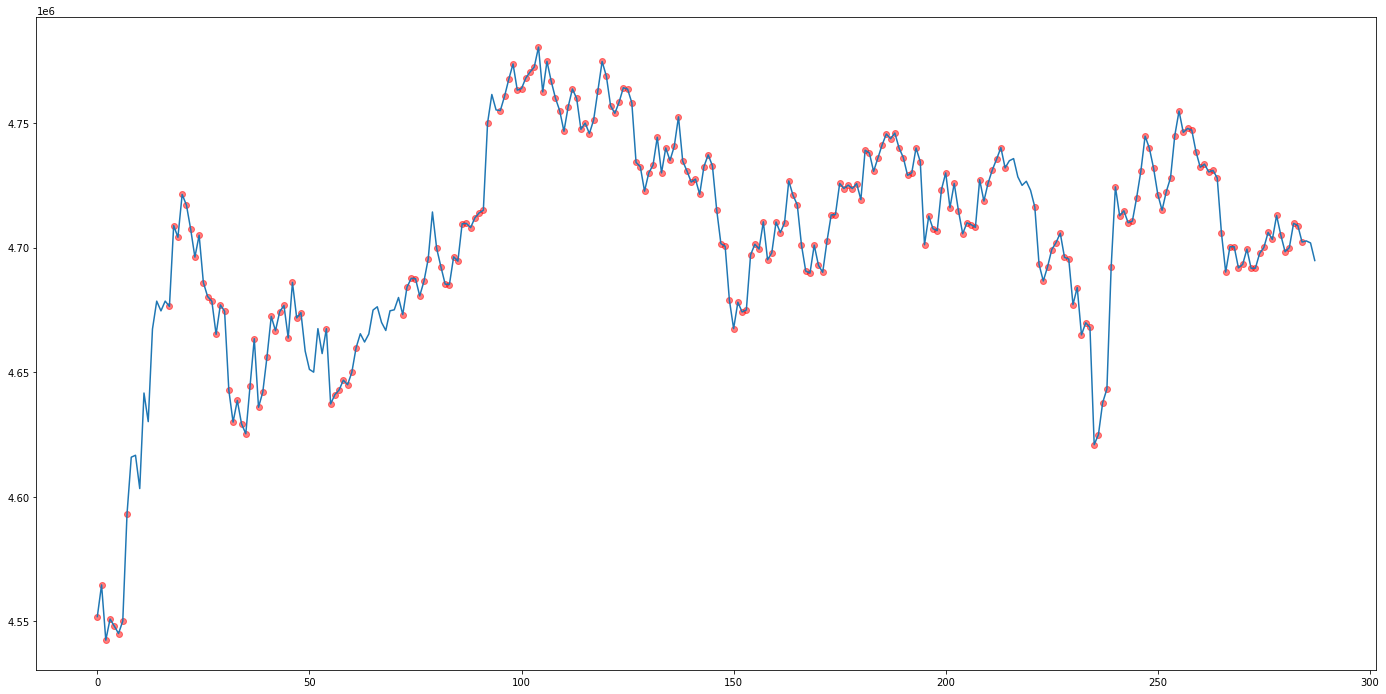

In [27]:
offset = 4000
end = 288
plt.figure(figsize=(24,12))
plt.plot(data.values[start+offset:start+offset+end, 0])
plt.scatter(np.where(buy_pre[offset:offset+end]==0)[0], data.values[start + offset + np.where(buy_pre[offset:offset+end]==0)[0], 0], color='red', alpha=0.5)

In [13]:
feature_value = np.array(list(features.values()))
del features

In [14]:
time_series = feature_value[np.where(labels[:,0]>=0.8), :, 0]

In [15]:
time_series = time_series.squeeze()

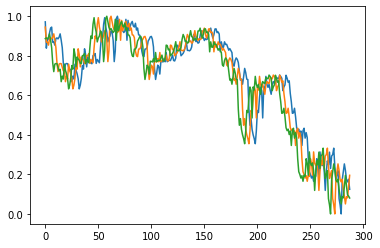

In [23]:
plt.plot(time_series[15000:15003].T)

In [55]:
labels = np.load('LSTM_model/labels/label_1d.npy', allow_pickle=True)

In [ ]:
data_temp = copy.deepcopy(data[400000:403000])
times = labels[labels['bin']==1.0].index
start = data_temp.index[0]
end = data_temp.index[-1]
times_temp = times[(times>=start) & (times<=end)]
data_temp.plot(figsize=(24, 12))
plt.scatter(x=times_temp, y=data_temp.loc[times_temp], color='red')
plt.scatter(x=t_events[(t_events>=start) & (t_events<=end)], y=data_temp.loc[t_events[(t_events>=start) & (t_events<=end)]], color='yellow', alpha=0.5)

In [13]:
import torch
import torch.nn as nn
con = nn.Conv1d(1,1,padding=(3,0),kernel_size=3)

In [11]:
t = torch.arange(10).reshape(1,1,10).float()

In [19]:
t.reshape(10,1,1).squeeze(1)

tensor([[0.],
        [1.],
        [2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])